In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier

from yellowbrick.classifier import ROCAUC, ConfusionMatrix
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from yellowbrick.style import set_palette




import os, shutil, joblib

import upsilon

# list_cephs = pd.DataFrame(os.listdir('../csv_data/SMC/cep/I/'))
# list_bin = pd.DataFrame(os.listdir('../csv_data/SMC/bin/I/'))

plt.style.use('fast')
set_palette('flatui')

-------------------------------
* WARNING: No pyFFTW detected *
-------------------------------


In [105]:
list_cephs = os.listdir('../csv_data/LMC/cep_2k/I/')
list_bin = os.listdir('../csv_data/LMC/bin_2k/I/')[:len(list_cephs)]
list_lyr = os.listdir('../csv_data/LMC/rrlyr_2k/I/')[:len(list_cephs)]

train_cephs, test_cephs = train_test_split(list_cephs, train_size = 0.7)
train_bin, test_bin = train_test_split(list_bin, train_size = 0.7)
train_lyr, test_lyr = train_test_split(list_lyr, train_size = 0.7)

In [54]:
def data_extraction(src: list, src_dir: str, object_class: str, validation_sample = False):
    # Set a list to store the samples for every object
    records = []
    records_val = []

    # For every file in a list of files (src), access it
    for file in src:

        # Set file path to then open light-curves 
        file_path = src_dir + file
        
        # Open .dat light-curve file
        with open(file_path, 'r') as f:

            # Create a DataFrame object with the data to more easily modify it later
            data = pd.read_table(f, delim_whitespace=True, names=["HJD-2450000", 'mag', 'err'])

            # Filter empty files
            if not data.empty and len(data) > 30:
                X_train, X_val = train_test_split(data, train_size = 0.3, shuffle = False)
                
                # Rename time column
                X_train = X_train.rename(columns={"HJD-2450000": "time"})
                X_train = X_train.sort_values(by = 'time')

                # Convert the columns to NumPy arrays
                time = X_train['time'].to_numpy()
                mag = X_train['mag'].to_numpy()
                err = X_train['err'].to_numpy()

                # Create an ExtractFeatures object and extract features
                e_features = upsilon.ExtractFeatures(time, mag, err)
                e_features.run()
                features = e_features.get_features()

                # Create a DataFrame with features and class
                feature_data = pd.DataFrame.from_dict(features, orient = 'index').T.drop(columns=['period_log10FAP'])

                feature_data['id'] = file
                feature_data['class'] = object_class
                # Append to the list of DataFrames
                records.append(feature_data)

                # Validation
                X_val = X_val.rename(columns={"HJD-2450000": "time"})
                X_val = X_val.sort_values(by = 'time')

                time_val = X_val['time'].to_numpy()
                mag_val = X_val['mag'].to_numpy()
                err_val = X_val['err'].to_numpy()

                # Create an ExtractFeatures object and extract features
                e_features_val = upsilon.ExtractFeatures(time_val, mag_val, err_val)
                e_features_val.run()
                features_val = e_features_val.get_features()

                # Create a DataFrame with features and class
                feature_data_val = pd.DataFrame.from_dict(features_val, orient = 'index').T.drop(columns=['period_log10FAP'])

                feature_data_val['id'] = file
                feature_data_val['class'] = object_class
                # Append to the list of DataFrames
                records_val.append(feature_data_val)

    if validation_sample:
        return pd.concat(records), pd.concat(records_val)
    else:
        return pd.concat(records)


In [38]:
def load_df(df_src: str):
    load_df = pd.read_csv(df_src)
    df = load_df.sample(frac=1)
    # df = pd.read_csv('../csv_data/test/train_df.csv')
    if 'Unnamed: 0' in df.columns:
        features = df.drop(columns = ['Unnamed: 0', 'id', 'class'])
        labels = df.pop('class')
    else:
        features = df.drop(columns = ['id', 'class'])
        labels = df.pop('class')
    # Create a LabelBinarizer object to binarize the labels
    # lb = LabelBinarizer()

    # # Binarize the label array (transform labels into binary form)
    # binarized_labels = lb.fit_transform(labels).ravel()

    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    encoder = LabelEncoder()
    numerized_labels = encoder.fit_transform(labels)
    scaled_features = StandardScaler().fit_transform(features)
    
    return scaled_features, numerized_labels

In [74]:
# def test_model(model, features, labels, is_binary = False):
#     for feature, label in zip(features, labels):
#         print("Start ---------------------------")
#         sizes = np.linspace(0.3, 1.0, 10)

#         cv = StratifiedKFold(n_splits=12)
#         viz = LearningCurve(model, cv=cv,  scoring='f1_weighted', train_sizes=sizes, n_jobs=4)

#         viz.fit(feature, label)        # Fit the data to the visualizer
#         viz.show() 


#         viz = ValidationCurve(
#             model, param_name="C",
#             param_range=np.arange(1, 11), cv=cv, scoring="r2"
#         )

#         # Fit and show the visualizer
#         viz.fit(feature, label)
#         viz.show()

#         # Instantiate the visualizer with the classification model
#         visualizer = ROCAUC(model, classes=[0, 1, 2], binary = is_binary)

#         visualizer.fit(features, label)        # Fit the training data to the visualizer
#         visualizer.score(feature, label)        # Evaluate the model on the test data
#         visualizer.show() 
#         print("End ---------------------------")
#     return None

def test_model(model, features, labels, is_binary=False):
    for feature, label in zip(features, labels):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a 1x3 subplot grid

        sizes = np.linspace(0.3, 1.0, 10)
        cv = StratifiedKFold(n_splits=12)

        # Learning Curve
        viz1 = LearningCurve(model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, ax=axes[0])
        viz1.fit(feature, label)
        axes[0].set_title('Learning Curve')  # Add title for the Learning Curve subplot
        # viz1.poof(is_fitted=True)  # Display legend for Learning Curve


        
        # Validation Curve
        viz2 = ValidationCurve(
            model, param_name="C",
            param_range=np.arange(1, 11), cv=cv, scoring="r2", ax=axes[1]
        )
        viz2.fit(feature, label)
        axes[1].set_title('Validation Curve')  # Add title for the Validation Curve subplot
        # viz2.poof(is_fitted=True)  # Display legend for Learning Curve


        # ROC AUC Curve
        viz3 = ROCAUC(model, classes=[0, 1, 2], binary=is_binary, ax=axes[2])
        viz3.fit(feature, label)
        viz3.score(feature, label)
        axes[2].set_title('ROC AUC Curve')  # Add title for the ROC AUC Curve subplot
        viz3.poof(is_fitted=True)  # Display legend for Learning Curve
        viz2.poof(is_fitted=True)  # Display legend for Learning Curve
        viz1.poof(is_fitted=True)  # Display legend for Learning Curve

        
        plt.tight_layout()
        plt.show()

    return None


In [115]:
def test_model(model, features, labels, is_binary=False):
    for feature, label in zip(features, labels):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a 1x3 subplot grid

        sizes = np.linspace(0.3, 1.0, 10)
        cv = StratifiedKFold(n_splits=12)

        # Learning Curve
        viz1 = LearningCurve(model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, ax=axes[0],)
        viz1.fit(feature, label)
        axes[0].set_title('Learning Curve')  # Add title for the Learning Curve subplot
        viz1.finalize()

        # Validation Curve
        viz2 = ValidationCurve(
            model, param_name="C",
            param_range=np.arange(1, 11), cv=cv, scoring="r2", ax=axes[1]
        )
        viz2.fit(feature, label)
        axes[1].set_title('Validation Curve')  # Add title for the Validation Curve subplot
        viz2.finalize()

        # ROC AUC Curve
        viz3 = ROCAUC(model, classes=[0, 1, 2], binary=is_binary, ax=axes[2])
        viz3.fit(feature, label)
        viz3.score(feature, label)
        axes[2].set_title('ROC AUC Curve')  # Add title for the ROC AUC Curve subplot
        viz3.finalize()
    fig.suptitle('Different types of oscillations', fontsize=16)

    # Display legends only once at the end
    plt.legend(['Learning Curve', 'Validation Curve', 'ROC AUC Curve'], loc='upper right')
    plt.tight_layout()
    plt.show()

    return None


### Train and val

In [29]:
# Call the data_extraction function to extract data for Cepheid stars
# src: list of Cepheid stars 
# src_dir: directory path where the Cepheid data files are located
# object_class: class label for Cepheids
cephs_train, cephs_val = data_extraction(src=test_cephs[:1000], src_dir='../csv_data/BLG/cep/I/', object_class='Cepheid',
                                        validation_sample = True)

# Call the data_extraction function to extract data for Binary stars
# src: list of Binary stars 
# src_dir: directory path where the Binary data files are located
# object_class: class label for Binary stars

bin_train, bin_val = data_extraction(src=test_bin[:1000], src_dir='../csv_data/BLG/bin/I/', object_class='Binary',
                                     validation_sample = True)

lyr_train, lyr_val = data_extraction(src=test_lyr[:1000], src_dir='../csv_data/BLG/rrlyr/I/', object_class='Lyrae',
                                     validation_sample = True)

# Concatenate the data extracted for Cepheids and Binary stars into a single DataFrame
train_df = pd.concat([cephs_train, bin_train, lyr_train], ignore_index=True)
val_df = pd.concat([cephs_val, bin_val, lyr_val], ignore_index=True)

train_df.to_csv('../csv_data/test/train_df_lyr.csv')
val_df.to_csv('../csv_data/test/val_df_lyr.csv')

c:\Users\momch\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Program

### Test

In [106]:
# Call the data_extraction function to extract data for Cepheid stars
# src: list of Cepheid stars 
# src_dir: directory path where the Cepheid data files are located
# object_class: class label for Cepheids
cephs_test = data_extraction(src=test_cephs, src_dir='../csv_data/LMC/cep_2k/I/', object_class='Cepheid',
                                        validation_sample = False)

# Call the data_extraction function to extract data for Binary stars
# src: list of Binary stars 
# src_dir: directory path where the Binary data files are located
# object_class: class label for Binary stars
bin_test = data_extraction(src=test_bin, src_dir='../csv_data/LMC/bin_2k/I/', object_class='Binary',
                                     validation_sample = False)

lyr_test = data_extraction(src=test_lyr, src_dir='../csv_data/LMC/rrlyr_2k/I/', object_class='Lyrae',
                                     validation_sample = False)

# Concatenate the data extracted for Cepheids and Binary stars into a single DataFrame
test_df = pd.concat([cephs_test, bin_test, lyr_test], ignore_index=True)

test_df.to_csv('../csv_data/test/val_df_lyr2.csv')

c:\Users\momch\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
c:\Users\momch\AppData\Local\Program

In [107]:
features_train, labels_train = load_df('../csv_data/test/train_df_lyr.csv')
features_test, labels_test = load_df('../csv_data/test/test_df_lyr.csv')
features_val, labels_val = load_df('../csv_data/test/val_df_lyr1.csv')
features_val2, labels_val2 = load_df('../csv_data/test/val_df_lyr2.csv')

In [108]:
model = LogisticRegression(max_iter = 10000)
log_reg = model.fit(features_train, labels_train)

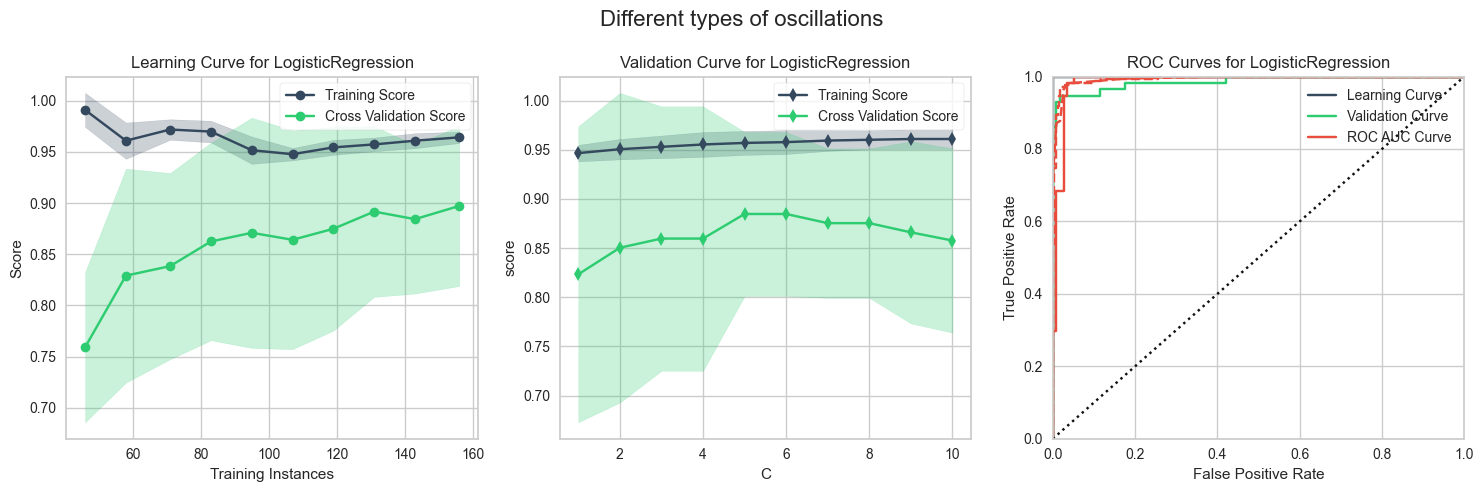

In [116]:
test_model(log_reg, [features_test], [labels_test])

In [112]:
'../csv_data/test/train_df.csv'.split('/')[-1]

'train_df.csv'